# A Meal's True Cost

The main goal of this Exploratory Data Analysis is to understand the environmental impact of each product we choose to eat and, therefore, the impact of our meals. By knowing this, we can change our consumption habits and improve our planet's health.
We'll start from a broad perspective, analyzing the general impact of food production on a worldwide scale in the form of water withdrawal, gas emissions and land use and comparing it to the impact of other industries. Then, we'll move to a specific country, Italy, to study the consumption habits of the citizens and the environmental effects caused by the top 15 consumed products.

In [1]:
import pandas as pd
from fuzzywuzzy import process, fuzz
import re
import matplotlib.pyplot as plt

## Getting and parsing the data

Firstly, we are going to parse the data we have. In this case, the main sources are:
- the FAO AQUASTAT database for information about worldwide water withdrawal
- the EFSA (European Food Safety Authority) food consumption data for data about the consumption of different types of food in various countries
- the data about water footprint of the watertofood project (part of the bigger CWASI dataset).

In [2]:
world_water_data = pd.read_csv("data/acquastat_world_water_withdrawal.csv", encoding="utf-8")
world_water_data

,VariableGroup,Subgroup,Variable,Area,Year,Value,Unit,Symbol,IsAggregate
0,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2020,11.627000,10^9 m3/year,E,True
1,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2021,14.047000,10^9 m3/year,E,True
2,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2022,14.397000,10^9 m3/year,E,True
3,Water use,Water withdrawal by sector,Agricultural water withdrawal,Central Asia,2020,93.197600,10^9 m3/year,E,True
4,Water use,Water withdrawal by sector,Agricultural water withdrawal,Central Asia,2021,85.003600,10^9 m3/year,E,True
...,...,...,...,...,...,...,...,...,...
985,Water use,Water withdrawal by sector,Water withdrawal for livestock (watering and c...,Western Asia,2021,0.388650,10^9 m3/year,E,True
986,Water use,Water withdrawal by sector,Water withdrawal for livestock (watering and c...,Western Asia,2022,0.388821,10^9 m3/year,E,True
987,Water use,Water withdrawal by sector,Water withdrawal for livestock (watering and c...,World,2020,31.018271,10^9 m3/year,E,True
988,Water use,Water withdrawal by sector,Water withdrawal for livestock (watering and c...,World,2021,31.276381,10^9 m3/year,E,True


In [3]:
# Load the food consumption data
food_consumption_data = pd.read_csv("data/chronic_consumption_gday_allsubjects.csv", encoding="utf-16")
food_consumption_data

,Survey's country,Survey start year,Survey name,Population Group (L2),Exposure hierarchy (L1),Exposure hierarchy (L2),Exposure hierarchy (L3),Exposure hierarchy (L4),Exposure hierarchy (L5),Exposure hierarchy (L6),...,Number of consumers,Mean,Standard Deviation,5th percentile,10th percentile,Median,95th percentile,97.5th percentile,99th percentile,Comment
0,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Beer and beer-like beverage,Beer,Beer,Beer,Beer,...,9,8.40,79.01,0.0,0.0,0.0,0.00,7.88,165.00,"'Number of observations lower than 298, the 99..."
1,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Unsweetened spirits and liqueurs,Liqueurs,Liqueurs,Liqueurs,Liqueurs,...,2,0.00,0.01,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
2,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Unsweetened spirits and liqueurs,Unsweetened spirits,Spirits from fruit,Spirits made from fruits other than stone fruits,Spirits made from fruits other than stone fruits,...,1,0.05,0.75,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
3,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Wine and wine-like drinks,Wine,Sparkling wine,Sparkling wine,Sparkling wine,...,1,0.08,1.28,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
4,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Wine and wine-like drinks,Wine,"Wine, red","Wine, red","Wine, red",...,16,1.19,15.21,0.0,0.0,0.0,0.09,0.12,2.96,"'Number of observations lower than 298, the 99..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,Italy,2018,Italian national dietary survey on adult popul...,Elderly,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, flavoured, no fruit",Soft drink with bitter principle,...,2,0.58,5.11,0.0,0.0,0.0,0.00,0.00,42.20,"'Number of observations lower than 180, the 97..."
1485,Italy,2018,Italian national dietary survey on adult popul...,Elderly,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, flavoured, no fruit","Soft drink, flavoured, no fruit",...,1,1.03,12.81,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 180, the 97..."
1486,Italy,2018,Italian national dietary survey on adult popul...,Elderly,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, flavoured, no fruit","Soft drink, lemon flavour",...,1,0.90,11.21,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 180, the 97..."
1487,Italy,2018,Italian national dietary survey on adult popul...,Elderly,Water and water-based beverages,Water based beverages,Soft drinks,Soft drinks with minor amounts of fruits or fl...,"Soft drink, with fruit juice (fruit content be...","Fruit soft drink, orange",...,2,0.91,8.14,0.0,0.0,0.0,0.00,0.00,64.95,"'Number of observations lower than 180, the 97..."


In [4]:
# Load the water to food data (no-animal)
watertofood_data = pd.read_csv("data/watertofood_data_italy.csv", encoding="utf-8", sep=";")
watertofood_data.columns = watertofood_data.columns.map(str)
watertofood_data

,Country Name,Country FAO Code,Country ISO2,Item Name,Item FAO Code,Item Category,Unit of Measure,1986,1987,1988,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Italy,106,IT,Wheat,15,Cereals,m3/ton,1192.040039,1180.640015,1278.810059,...,1152.670044,1017.260010,1069.989990,1055.760010,1025.219971,1006.349976,965.919983,966.867004,997.875000,945.799011
1,Italy,106,IT,Flour of Wheat,16,Cereals,m3/ton,1206.209961,1194.670044,1294.020020,...,1166.369995,1029.349976,1082.709961,1068.319946,1206.209961,1194.670044,1294.020020,1306.260010,1208.140015,1000.450012
2,Italy,106,IT,Macaroni,18,Cereals,m3/ton,1206.209961,1194.670044,1294.020020,...,1166.369995,1029.349976,1082.709961,1068.319946,1206.209961,1194.670044,1294.020020,1306.260010,1208.140015,1000.450012
3,Italy,106,IT,Bread,20,Cereals,m3/ton,1048.880005,1038.849976,1125.229980,...,1014.239990,895.086975,941.487000,928.971008,1048.880005,1038.849976,1125.229980,1135.880005,1050.550049,869.960022
4,Italy,106,IT,Bulgur,21,Cereals,m3/ton,1328.510010,1315.810059,1425.219971,...,1284.640015,1133.719971,1192.489990,1176.640015,1328.510010,1315.810059,1425.219971,1438.709961,1330.640015,1101.890015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Italy,106,IT,Coir,813,Non edible,m3/ton,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
258,Italy,106,IT,Fibre Crops Nes,821,Non edible,m3/ton,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
259,Italy,106,IT,"Tobacco, unmanufactured",826,Non edible,m3/ton,1466.040039,1292.319946,1322.020020,...,859.124023,901.718994,890.434998,1001.070007,885.098022,868.867981,940.674011,974.122009,892.125000,1214.290039
260,Italy,106,IT,Natural rubber,836,Non edible,m3/ton,16886.400391,17445.400391,16030.099609,...,10232.200195,12974.000000,11783.299805,9563.639648,9968.230469,0.000000,10898.299805,12146.099609,12941.299805,12130.500000


In [5]:
# loading dataset on water consumption for animal products
watertofood_animals = pd.read_csv("data/watertofood_data_italy_animal.csv", encoding="utf-8", sep=";")
watertofood_animals.columns = watertofood_animals.columns.map(str)
watertofood_animals

,Country Name,Country FAO Code,Country ISO2,Item Name,Item FAO Code,Item Category,Unit of Measure,Value
0,Italy,106,IT,Cattle,866,Live animals,m3/ton,5094.3
1,Italy,106,IT,Cattle meat,867,Meat,m3/ton,7521.7
2,Italy,106,IT,"Offals of cattle, edible",868,Meat,m3/ton,7605.0
3,Italy,106,IT,"Fat, cattle",869,Meat,m3/ton,7605.0
4,Italy,106,IT,"Meat-Cattle, boneless",870,Meat,m3/ton,10596.7
...,...,...,...,...,...,...,...,...
84,Italy,106,IT,"Meat, nes",1166,Meat,m3/ton,1278.8
85,Italy,106,IT,"Offals, nes",1167,Meat,m3/ton,1171.5
86,Italy,106,IT,"Oils, fats of animal nes",1168,Meat,m3/ton,2358.7
87,Italy,106,IT,"Meal, meat",1173,Meat,m3/ton,1278.8


In [9]:
# loading dataset on land use
landuse_data = pd.read_csv("data/FAOSTAT_land_use_data.csv", encoding="utf-8")
landuse_data.head(10)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,RL,Land Use,1,World,5110,Area,6601,Land area,2016,2016,1000 ha,1.303177e+07,E,Estimated value,NaN
1,RL,Land Use,1,World,5110,Area,6601,Land area,2017,2017,1000 ha,1.303124e+07,E,Estimated value,NaN
2,RL,Land Use,1,World,5110,Area,6601,Land area,2018,2018,1000 ha,1.303152e+07,B,Time series break,NaN
3,RL,Land Use,1,World,5110,Area,6602,Agriculture,2016,2016,1000 ha,4.831958e+06,E,Estimated value,NaN
4,RL,Land Use,1,World,5110,Area,6602,Agriculture,2017,2017,1000 ha,4.855317e+06,E,Estimated value,NaN
5,RL,Land Use,1,World,5110,Area,6602,Agriculture,2018,2018,1000 ha,4.841329e+06,B,Time series break,NaN
6,RL,Land Use,1,World,5110,Area,6610,Agricultural land,2016,2016,1000 ha,4.785695e+06,E,Estimated value,NaN
7,RL,Land Use,1,World,5110,Area,6610,Agricultural land,2017,2017,1000 ha,4.815944e+06,E,Estimated value,NaN
8,RL,Land Use,1,World,5110,Area,6610,Agricultural land,2018,2018,1000 ha,4.804410e+06,E,Estimated value,NaN
9,RL,Land Use,1,World,5110,Area,6620,Cropland,2016,2016,1000 ha,1.557773e+06,E,Estimated value,NaN


## Worldwide impact of food production
### How much water is used to produce food?

In [6]:
# Define the variables of interest
variables_of_interest = [
    "Agricultural water withdrawal as % of total water withdrawal",
    "Industrial water withdrawal as % of total water withdrawal",
    "Municipal water withdrawal as % of total withdrawal"
]

# Filter the dataframe
filtered = world_water_data[
    (world_water_data["Variable"].isin(variables_of_interest)) &
    (world_water_data["Year"] == 2022) &
    (world_water_data["Area"] == "World")
]

# Extract lists
selected_variables = filtered["Variable"].tolist()
selected_values = filtered["Value"].tolist()

print("Selected Variables:", selected_variables)
print("Selected Values:", selected_values)

Selected Variables: ['Agricultural water withdrawal as % of total water withdrawal', 'Industrial water withdrawal as % of total water withdrawal', 'Municipal water withdrawal as % of total withdrawal']
Selected Values: [71.472993083, 15.286538825, 13.214705355]


([<matplotlib.patches.Wedge at 0x1f3579c7010>,
 [Text(-0.6875351703354871, 0.8586590647933282, 'Agricultural water withdrawal as % of total water withdrawal'),
  Text(0.28269660771468125, -1.0630534454986784, 'Industrial water withdrawal as % of total water withdrawal'),
  Text(1.0065129672431778, -0.4437698128211673, 'Municipal water withdrawal as % of total withdrawal')])

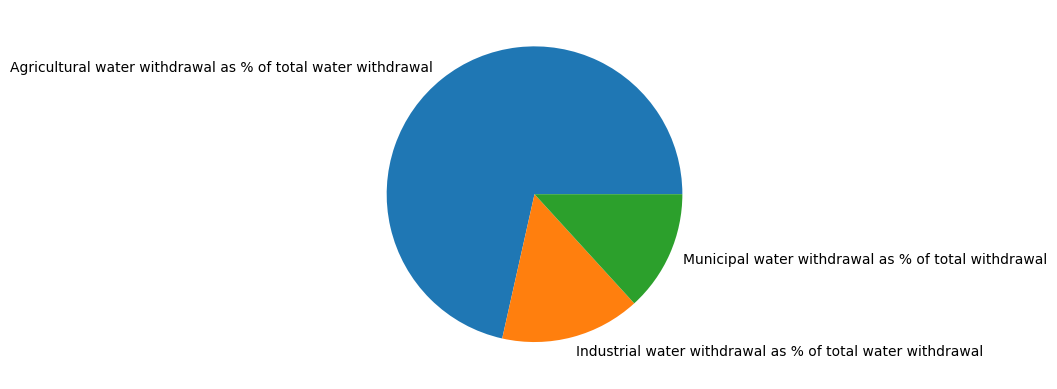

In [7]:
labels = selected_variables
sizes = selected_values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)

### How much land is it used for food production?

In [14]:
# Filter the land use data
filtered_landuse = landuse_data[
    (landuse_data["Area"] == "World") &
    (landuse_data["Year"] == 2018) &
    (landuse_data["Item"].isin(["Agriculture", "Land area"]))
]

filtered_landuse = filtered_landuse[["Area", "Year", "Item", "Value"]]
filtered_landuse

,Area,Year,Item,Value
2,World,2018,Land area,1.303152e+07
5,World,2018,Agriculture,4.841329e+06


In [19]:
land_area = filtered_landuse["Value"].iloc[0]
agriculture_area = filtered_landuse["Value"].iloc[1]

# percentage of land used for agriculture
agriculture_percentage = (agriculture_area / land_area) * 100
print(f"Percentage of land used for agriculture: {agriculture_percentage:.2f}%")

Percentage of land used for agriculture: 37.15%


([<matplotlib.patches.Wedge at 0x1f357a14820>,
 [Text(0.4320717769310012, 1.0115898277363644, 'land used for agriculture'),
  Text(-0.43207156790409235, -1.0115899170162281, 'land used for other purposes')])

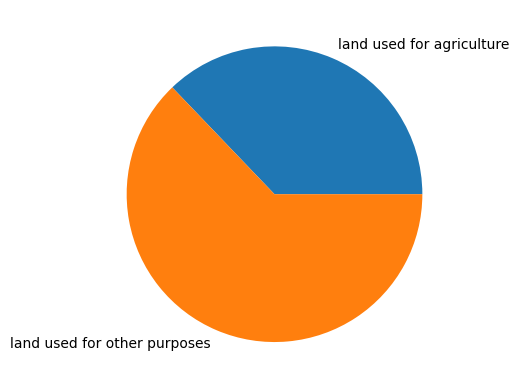

In [20]:
labels = ["land used for agriculture", "land used for other purposes"]
sizes = [agriculture_percentage, 100 - agriculture_percentage]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)

## Which are the most consumed types of food in Italy?

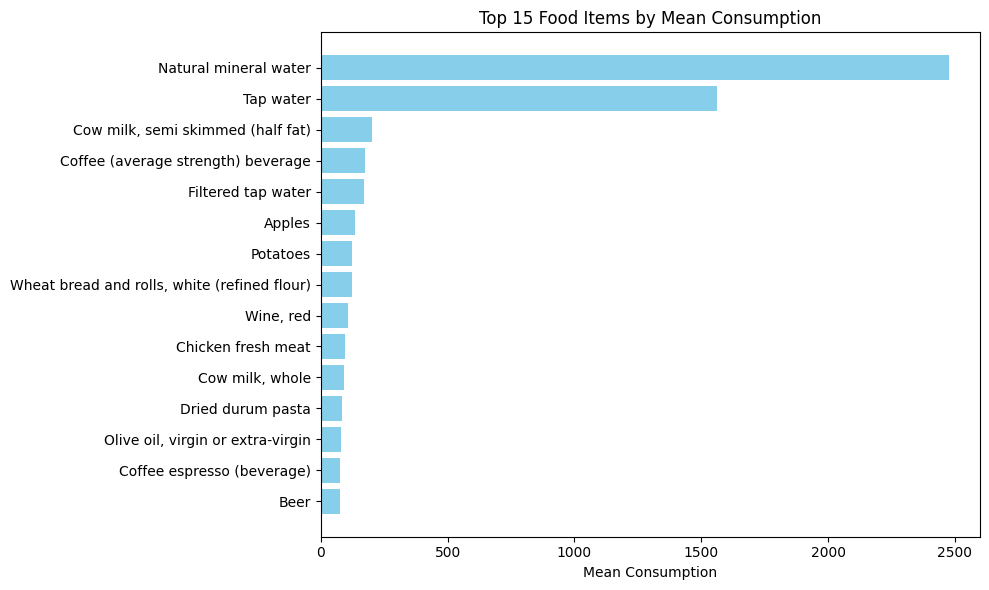

In [18]:
# Group by 'Exposure hierarchy (L7)', sum the 'Mean' values, and get the top 15
top15 = (
    food_consumption_data
    .groupby('Exposure hierarchy (L7)', as_index=False)['Mean']
    .sum()
    .sort_values('Mean', ascending=False)
    .head(15)
)

# Extract lists
selected_variables = top15["Exposure hierarchy (L7)"].tolist()
selected_values = top15["Mean"].tolist()

# Create a bar plot for the top 15 food items
plt.figure(figsize=(10, 6))
plt.barh(selected_variables, selected_values, color='skyblue')
plt.xlabel('Mean Consumption')
plt.title('Top 15 Food Items by Mean Consumption')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
plt.tight_layout()
plt.show()

,Country Name,Country FAO Code,Country ISO2,Item Name,Item FAO Code,Item Category,Unit of Measure,1986,1987,1988,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Italy,106,IT,Wheat,15,Cereals,m3/ton,1192.040039,1180.640015,1278.810059,...,1152.670044,1017.260010,1069.989990,1055.760010,1025.219971,1006.349976,965.919983,966.867004,997.875000,945.799011
1,Italy,106,IT,Flour of Wheat,16,Cereals,m3/ton,1206.209961,1194.670044,1294.020020,...,1166.369995,1029.349976,1082.709961,1068.319946,1206.209961,1194.670044,1294.020020,1306.260010,1208.140015,1000.450012
2,Italy,106,IT,Macaroni,18,Cereals,m3/ton,1206.209961,1194.670044,1294.020020,...,1166.369995,1029.349976,1082.709961,1068.319946,1206.209961,1194.670044,1294.020020,1306.260010,1208.140015,1000.450012
3,Italy,106,IT,Bread,20,Cereals,m3/ton,1048.880005,1038.849976,1125.229980,...,1014.239990,895.086975,941.487000,928.971008,1048.880005,1038.849976,1125.229980,1135.880005,1050.550049,869.960022
4,Italy,106,IT,Bulgur,21,Cereals,m3/ton,1328.510010,1315.810059,1425.219971,...,1284.640015,1133.719971,1192.489990,1176.640015,1328.510010,1315.810059,1425.219971,1438.709961,1330.640015,1101.890015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Italy,106,IT,Coir,813,Non edible,m3/ton,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
258,Italy,106,IT,Fibre Crops Nes,821,Non edible,m3/ton,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
259,Italy,106,IT,"Tobacco, unmanufactured",826,Non edible,m3/ton,1466.040039,1292.319946,1322.020020,...,859.124023,901.718994,890.434998,1001.070007,885.098022,868.867981,940.674011,974.122009,892.125000,1214.290039
260,Italy,106,IT,Natural rubber,836,Non edible,m3/ton,16886.400391,17445.400391,16030.099609,...,10232.200195,12974.000000,11783.299805,9563.639648,9968.230469,0.000000,10898.299805,12146.099609,12941.299805,12130.500000


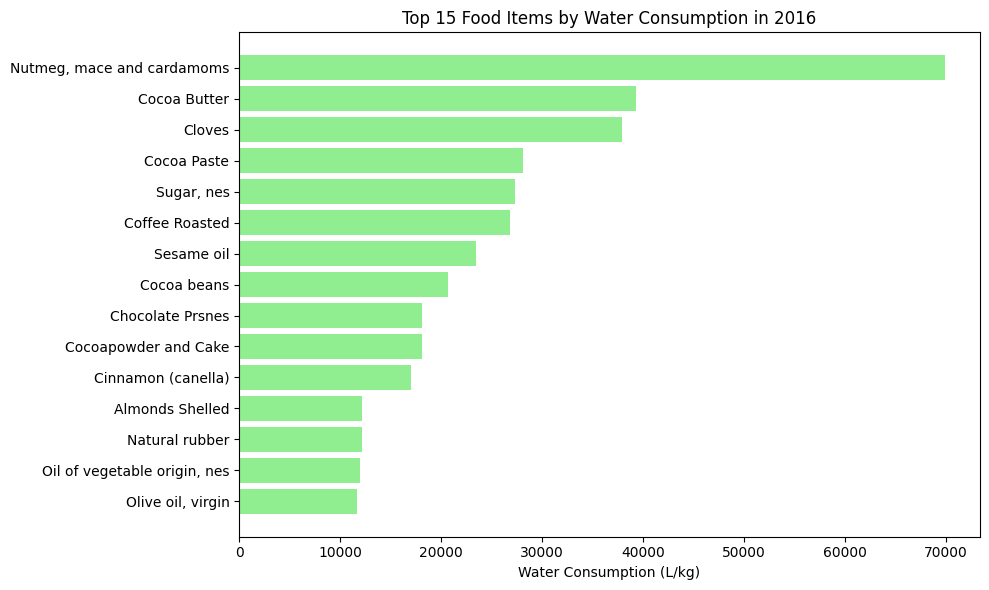

In [22]:
# Select the top 15 rows with the highest values in the "2016" column
top15_2016 = (
    watertofood_data[["Item Name", "2016"]]
    .sort_values("2016", ascending=False)
    .head(15)
    .reset_index(drop=True)
)

selected_variables = top15_2016["Item Name"].tolist()
selected_values = top15_2016["2016"].tolist()

# Create a bar plot for the top 15 food items in 2016
plt.figure(figsize=(10, 6))
plt.barh(selected_variables, selected_values, color='lightgreen')
plt.xlabel('Water Consumption (L/kg)')
plt.title('Top 15 Food Items by Water Consumption in 2016')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value
plt.tight_layout()
plt.show()

In [6]:
# Search for matches between 'Item Name' in watertofood_data and 'Exposure hierarchy (L7)' in food_consumption_data
# Create a list to store matches
matches = []

# Lowercase exposure values for matching
exposure_values = food_consumption_data['Exposure hierarchy (L7)'].astype(str).str.lower().unique()

for item in watertofood_data['Item Name']:
    item_lower = str(item).lower()
    for exposure in exposure_values:
        # Check for exact or partial match
        if exposure in item_lower or item_lower in exposure:
            matches.append({'Item Name': item, 'Exposure hierarchy (L7)': exposure})
            break  # Stop at first match

# Create the resulting DataFrame
matches_df = pd.DataFrame(matches)

# Display all rows with columns side by side in the console
with pd.option_context('display.max_rows', None, 'display.width', None):
    print(matches_df.to_string(index=False))

                         Item Name                  Exposure hierarchy (L7)
                             Wheat                        wheat crisp bread
                             Bread                    fish fingers, breaded
                            Barley                   barley coffee infusion
                    Beer of Barley                                     beer
                             Maize                        maize oil, edible
                         Maize oil                        maize oil, edible
                               Rye rye-wheat bread and rolls, refined flour
                              Oats                               oats drink
                            Millet                      common millet grain
                         Buckwheat                                buckwheat
                            Quinoa                             quinoa grain
                          Potatoes                                 potatoes
            

In [7]:
# Search for correspondence between top 15 exposures and Item Name in watertofood_data
# Prepare a list of Item Name values
item_names = watertofood_data['Item Name'].astype(str).tolist()

results = []

for exposure in top15['Exposure hierarchy (L7)']:
    # Find the best match in Item Name for each exposure value
    match, score = process.extractOne(str(exposure), item_names)
    # Set a threshold for match quality (e.g., 70)
    if score >= 70:
        # Get the corresponding row for the matched Item Name
        matched_row = watertofood_data[watertofood_data['Item Name'] == match].iloc[0]
        results.append({
            'Exposure hierarchy (L7)': exposure,
            'Item Name': match,
            '2016': matched_row['2016']
        })

# Create the resulting DataFrame
correspondence_df = pd.DataFrame(results)

print(correspondence_df)

                         Exposure hierarchy (L7)          Item Name  \
0                          Natural mineral water     Natural rubber   
1              Cow milk, semi skimmed (half fat)      Cow peas, dry   
2             Coffee (average strength) beverage      Coffee, green   
3                                         Apples             Apples   
4                                       Potatoes           Potatoes   
5   Wheat bread and rolls, white (refined flour)     Flour of Wheat   
6                                      Wine, red               Wine   
7                              Dried durum pasta         Figs dried   
8              Olive oil, virgin or extra-virgin  Olive oil, virgin   
9                     Coffee espresso (beverage)      Coffee, green   
10                                          Beer     Beer of Barley   

            2016  
0   12130.500000  
1       0.000000  
2   11065.099609  
3     166.037994  
4     122.105003  
5    1000.450012  
6     633.2180

In [9]:
# Search for correspondence between top 15 exposures and Item Name in watertofood_animals
# Preprocessing function
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.replace('skm', 'skimmed')  # Expand abbreviation
    text = ' '.join(text.split())  # Remove extra whitespace
    return text

# Preprocess Item Name values and keep mapping to original
watertofood_animals['Item Name Preprocessed'] = watertofood_animals['Item Name'].apply(preprocess)
item_names_animal = watertofood_animals['Item Name Preprocessed'].tolist()

results = []

for exposure in top15['Exposure hierarchy (L7)']:
    exposure_preprocessed = preprocess(exposure)
    # Find the best match in preprocessed Item Name for each preprocessed exposure value
    match, score = process.extractOne(exposure_preprocessed, item_names_animal, scorer=fuzz.token_sort_ratio)
    if score >= 70:
        # Get the corresponding row for the matched preprocessed Item Name
        matched_row = watertofood_animals[watertofood_animals['Item Name Preprocessed'] == match].iloc[0]
        results.append({
            'Exposure hierarchy (L7)': exposure,
            'Item Name': matched_row['Item Name'],
            'Value': matched_row['Value']
        })

# Create the resulting DataFrame
correspondence_animals_df = pd.DataFrame(results)

print(correspondence_animals_df)

  Exposure hierarchy (L7)        Item Name   Value
0      Chicken fresh meat    Meat, chicken  2358.7
1         Cow milk, whole  Milk Whole Cond  1270.7
